[Kaggle Code Review](https://www.kaggle.com/code/romaupgini/guide-external-data-features-for-multivariatets)


# Setting

In [2]:
%pip install -Uq upgini

     |████████████████████████████████| 74 kB 2.6 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.5 MB 41.9 MB/s 
     |████████████████████████████████| 1.6 MB 52.7 MB/s 


**upgini**

: a feature search and enrichment library in Python 

  (feature를 생성해주는 파이썬 라이브러리)
- searches through thousands of public and community data sources and then creates features that enrich the capabilities of our models 

  (모델의 성능을 높여주는 features를 생성함)
- new features improve the prediction power of the models
  
  (새로 생성된 feature는 모델의 예측 성능을 높임)

In [3]:
import numpy as np
import pandas as pd

# statics module
import statsmodels.api as sm
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# visualization tools
from matplotlib import pyplot as plt, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from tqdm import tqdm

# memory control tool
import gc
gc.enable()

# warning control tool
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

**statsmodels**

: a Python module that provides classes and functions for the estimation of many different statistical models

(통계학 모델을 위한 class와 function을 제공해주는 파이썬 모듈)


# Load Data
- store sales `time series` data

## Train data

**Data Info**

`store_nbr` : identifies the store at which the products are sold (제품이 팔린 매장에 대한 정보)

`family` : identifies the type of product sold (팔린 제품 종류)

`sales` : gives the total sales for a product family at a particular store at a given date (그 날 팔린 제품의 종류별 판매량)
- 소수점으로 판매 가능 (float형 처리)

`onpromotion` : gives the total number of items in a product family that were being promoted at a store at a given date (정해진 기간동안 팔린 제품의 종류별 총 판매량)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/train.csv',
                    
                    # 날짜 파싱하기
                    parse_dates = ['date'], infer_datetime_format = True,

                    # 데이터 타입 설정
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                    
                    # 불러올 column 설정
                    usecols = ['date', 'store_nbr', 'family', 'sales'])

# Timestamp를 하루 단위로 변환
train['date'] = train.date.dt.to_period('D')

# 특정 column을 인덱스로 설정한 후 정렬
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()


print(train.shape)

(3000888, 1)


In [7]:
train.head(10)

sales
date       store_nbr family             
2013-01-01 1         AUTOMOTIVE      0.0
                     BABY CARE       0.0
                     BEAUTY          0.0
                     BEVERAGES       0.0
                     BOOKS           0.0
                     BREAD/BAKERY    0.0
                     CELEBRATION     0.0
                     CLEANING        0.0
                     DAIRY           0.0
                     DELI            0.0

`Output `

날짜와 매장으로 묶어 제품 종류별 판매량으로 정리했다.

## Test data

In [8]:
test = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)

test['date'] = test.date.dt.to_period('D')

# 특정 column을 인덱스로 설정한 후 id로 정렬
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')

print(test.shape)

(28512, 2)


In [10]:
test.head(10)

id  onpromotion
date       store_nbr family                            
2017-08-16 1         AUTOMOTIVE    3000888            0
                     BABY CARE     3000889            0
                     BEAUTY        3000890            2
                     BEVERAGES     3000891           20
                     BOOKS         3000892            0
                     BREAD/BAKERY  3000893           12
                     CELEBRATION   3000894            0
                     CLEANING      3000895           25
                     DAIRY         3000896           45
                     DELI          3000897           18

# Data preprocessing

## Load Raw Features

### Oil price lag features

**Data Info**

`dcoilwtico` : Daily oil price (일별 유가)

In [11]:
# Load oil data
oil = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,

                  # 'date'열을 index로 가져옴
                  index_col = 'date').to_period('D') # DatetimeIndex를 PeriodIndex로 변환하는 메서드 (하루 단위로 변환)

In [36]:
oil.head(10)

,dcoilwtico,avg_oil
date,,
2013-01-01,NaN,NaN
2013-01-02,93.14,NaN
2013-01-03,92.97,NaN
2013-01-04,93.12,NaN
2013-01-07,93.20,NaN
2013-01-08,93.21,NaN
2013-01-09,93.08,NaN
2013-01-10,93.81,93.218571
2013-01-11,93.60,93.284286


- **결측치 확인**

  : 총 43개의 결측치가 확인되므로, 결측치 처리가 필요함

In [12]:
oil.isnull().sum()

dcoilwtico    43
dtype: int64

- **결측치 처리**

  : 이동평균을 이용하여 결측치를 대체함

In [13]:
# 정해진 기간을 하루 단위의 PeriodIndex로 변환하여 calendar로 저장함
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')

# 7개씩 이동평균 계산
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()

oil['avg_oil']

date
2013-01-01          NaN
2013-01-02          NaN
2013-01-03          NaN
2013-01-04          NaN
2013-01-07          NaN
                ...    
2017-08-25    47.720000
2017-08-28    47.624286
2017-08-29    47.320000
2017-08-30    47.115714
2017-08-31    47.060000
Freq: D, Name: avg_oil, Length: 1218, dtype: float64

**Pandas.series.rolling.mean()**

: 데이터 프레임 속 데이터들의 이동평균을 계산해줌

`Output `

NaN으로 뜨는 날짜에는 데이터가 7개 미만이므로, 해당 날짜에는 결측치가 포함되어있음을 알 수 있다.

In [14]:
# calendar에 oil 이동평균을 문자열로 합쳐서 변환함
calendar = calendar.join(oil.avg_oil)

# 결측치 채워넣기
# 'avg_oil' column값의 결측치를 바로 윗 값으로 채워넣음
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)

# 결측치 제거
# 남아있는 결측치 모두 제거
calendar.dropna(inplace = True)

# 결측치 확인
calendar.avg_oil.isnull().sum()

0

**fillna**

: DataFrame에서 결측값을 원하는 값으로 변경하는 메서드

- `ffill` : 결측값을 바로 위 값과 동일하게 변경함
- `inplace = True` : 원본을 변경함 (원본을 변경할지의 여부)

**dropna**

: DataFramde내의 결측값이 포함된 레이블을 제거하는 메서드

- `inplace` : 원본을 변경할지의 여부

`Output `

결측치가 모두 이동평균으로 대체되어 더이상 결측치가 남아있지 않음을 확인할 수 있다.

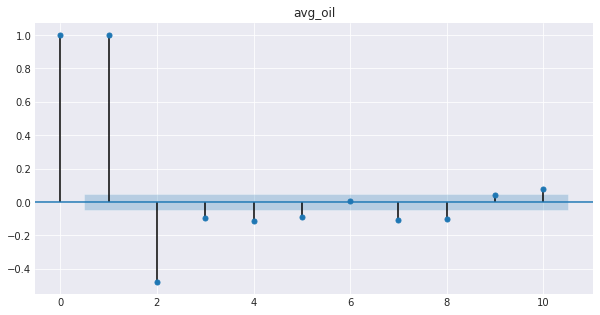

In [28]:
# PACF graph 사이즈 조정하기
# N : 가로, M : 세로
N, M = 10, 5
fig, ax = plt.subplots(figsize=(N, M))

# PACF graph 그리기
plot_pacf(calendar.avg_oil, lags = 10, title='avg_oil', ax=ax)

plt.show()

**PACF, 편자기상관함수**

: 시계열 분석으로 도출된 잔차가 시간의 흐름에 따라 상관성이 존재하는지 편미분을 통해 확인하는 함수

- `plot_pacf` : 시계열 데이터의 특성을 파악할 수 있는 중요한 지표
- `avg.oil`값이 상관성을 가지는지 확인하기 위해 사용되었음

`Output `

lags가 3개까지 파란 영역에서 많이 벗어나있다. 즉 자기상관계수가 매우 높거나 낮아 신뢰수준을 만족하지 못하므로, lags=3까지의 수준에서 통계적 유의성을 찾을 수 없다는 의미다. 따라서 이를 제외하고 다시 계산한다.

- 첫번째 lag는 자기자신의 상관관계이므로 항상 1이다.

In [29]:
n_lags = 3

# lags=3 이후의 값들을 가지고 계산
for l in range(1, n_lags + 1):
    calendar[f'oil_lags{l}'] = calendar.avg_oil.shift(l)

# 결측치 제거
calendar.dropna(inplace = True)

`Output `

lag의 수를 조정하여 차분한 데이터다.

**Question?**

- 차분한 데이터를 가진 PACF 그래프를 그리는 방법?
- `Oil price lags for the first 3 days should be enough`의 의미? 
  - 3개까지 측정하면 되는게 아니라, 첫 3개를 제외하고 다시 측정해야하는 것 아님?

### Holiday features

**Data Info**

`type` : type of holiday (휴일 종류)
- `Holiday` : 휴일
- `Transfer` : 이전에 휴일이었으나, 평상일로 바뀌었음 (그러나 사람들의 기분은 휴일과 같다고 고려함)
- `Additional` : 휴일 전후 휴일과 같은 날 (ex. 크리스마스 이브)
- `Bridge` : 대체 휴일 
- `Work day` : 대체 휴일을 메꾸기위해 일하는 주말

`transferred` : 평상일에서 휴일로 변경되었는지 여부
- `True` : 평상일에서 휴일로 변경됨
- `False` : 나머지

`locale` : 휴일이 시행된 지역
- `local` : 좁은 지역
- `regional` : 넓은 지역
- `National` : 전국적으로 시행

`locale_name` : location name (지역 이름)

`description` : description of holiday (휴일 이름)

In [33]:
hol = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')

# 전국적으로 시행된 'National' loacale만 가져옴 (false positive 발생을 방지함)             
hol = hol[hol.locale == 'National']  # Only National holidays so there'll be no false positive.

# 그룹 내 결측치가 아닌 값 중에서 첫번째 값으로 묶음 (holiday가 여러개 겹치는 경우를 방지함)
hol = hol.groupby(hol.index).first() # Remove duplicated holidays

print(hol.shape)

(168, 5)


**Question?**

- False positive가 발생하는 이유는 같은 날짜에 지역에 따라 Holiday로 선정될수도 있고 선정되지 않을수도 있기 때문?
- False negative도 발생할 수 있으나, 보통 False positive에 비중을 크게 두므로 이것만 언급된 것?

In [35]:
hol.head(10)

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
2012-12-21,Additional,National,Ecuador,Navidad-4,False
2012-12-22,Additional,National,Ecuador,Navidad-3,False
2012-12-23,Additional,National,Ecuador,Navidad-2,False
2012-12-24,Bridge,National,Ecuador,Puente Navidad,False


`Output `

National locale이 날짜별로 묶여있다.

- **결측치 확인**

  : 결측치가 없으므로, 따로 결측치 처리가 필요없음

In [37]:
hol.isnull().sum()

type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

- **One-hot encoding**

  : `Holiday features`는 범주형 자료이므로, 수치형 자료로 바꿔 정보 손실 없이 범주형 자료를 그룹화하기위해 One-hot encoding을 해야함

  - 범주형 데이터 전처리 방법
  - 범주형 데이터는 분석 단계에서 계산이 어렵기 때문에 숫자형으로 변경이 필요함

In [38]:
# calendar에 holiday dataset을 문자열로 합쳐서 변환함
calendar = calendar.join(hol)               # Joining calendar with holiday dataset

calendar.head()

,avg_oil,oil_lags1,oil_lags2,oil_lags3,type,locale,locale_name,description,transferred
2013-01-13,93.284286,93.284286,93.284286,93.218571,NaN,NaN,NaN,NaN,NaN
2013-01-14,93.470000,93.284286,93.284286,93.284286,NaN,NaN,NaN,NaN,NaN
2013-01-15,93.490000,93.470000,93.284286,93.284286,NaN,NaN,NaN,NaN,NaN
2013-01-16,93.644286,93.490000,93.470000,93.284286,NaN,NaN,NaN,NaN,NaN
2013-01-17,93.970000,93.644286,93.490000,93.470000,NaN,NaN,NaN,NaN,NaN


In [39]:
# Return the day of the week (Monday=0, Sunday=6으로 요일을 반환함)
calendar['dofw'] = calendar.index.dayofweek # Day of week

# Week day = wd라고 정의함
calendar['wd'] = 1

# Weekday = 평일
# Weekday 아님 = 주말
# Workday = 일하는 날
# Workday 아님 = 휴일

# calendar.dofw > 4 (토요일, 일요일)은 Weekday가 아니라고 정의함 -> wd = 0
calendar.loc[calendar.dofw > 4, 'wd'] = 0   # If it's saturday or sunday then it's not Weekday

# calendar.type == 'Work Day'은 Workday로 정의함 -> wd = 1
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday

# calendar.type == 'Transfer' (평상일에서 변경된 휴일)은 Workday가 아님 -> wd = 0
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a work day

# calendar.type == 'Bridge' (대체 휴일)은 Workday가 아님 -> wd = 0
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a work day

# Holiday고 변경되지 않았으므로, 휴일임 -> wd = 0
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's non working day

# Holiday였지만 평상일로 변경되었으므로, Workday임 -> wd = 1
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's working day

# One-hot Encoding
# dofw의 첫번째 값은 dofw에 대한
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)

# 불필요한 column값 제거
# Holiday type과 날짜에 대해서만 고려하므로 나머지 column값은 제거함
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns

print(calendar.shape)

(1692, 17)


**pd.get_dummies**

: 결측값을 제외하고 0과 1로 구성된 더미값이 만듬
- 숫자형이 아닌 모든 컬럼들에 대해서 원핫인코딩(one-hot encoding)을 진행함
- `drop_first = True` : 첫번째 카테고리 값은 사용하지 않음

In [40]:
calendar.head(10)

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-18,94.331429,93.970000,93.644286,93.490000,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-19,94.331429,94.331429,93.970000,93.644286,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-20,94.331429,94.331429,94.331429,93.970000,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-21,94.331429,94.331429,94.331429,94.331429,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-22,94.331429,94.331429,94.331429,94.331429,1,1,0,0,0,0,0,0,0,0,0,0,0


**Question?**

- columns = ['dofw']에서 왜 첫번째 column값 제거?
- columns = ['type']에서 왜 첫번째 column값 제거하지 않음?
  - `there's a "No holiday" already`의 의미?

## Feature Construction

### Time dependent features

**Feature Info**

`SCHOOL AND OFFICE SUPPLIES`와 같은 공공부문의 임금은 매월 2주마다 15일과 말일에 입금된다.

- `wageday` : 임급지급일, 따로 `SCHOOL AND OFFICE SUPPLIES`에 대한 날짜를 빼서 지정함

In [42]:
# 'wageday' column값 생성
calendar['wageday']=0

# 15일과 말일에 wageday = 1
calendar.loc[(calendar.index.to_timestamp().is_month_end) | (calendar.index.day == 15), 'wageday'] = 1

**Question?**

- `wageday`를 설정한 이유? 15일과 말일에 급증하는 판매량에 대한 이해를 돕기 위해서?

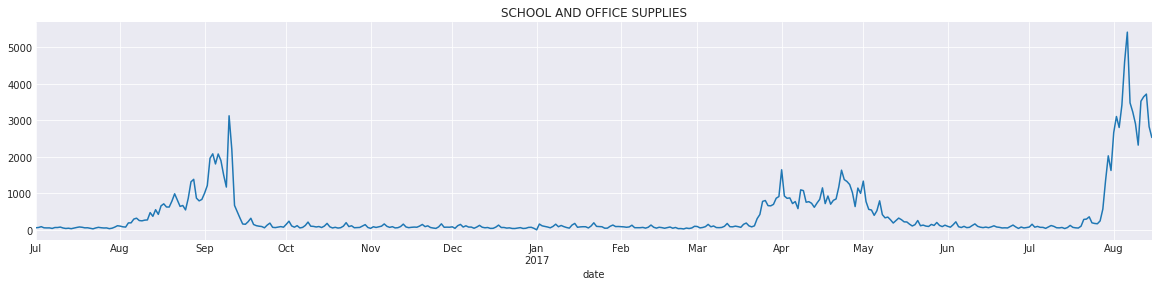

In [43]:
# graph 사이즈 조정
ax = plt.subplots(1,1,figsize = (20,4))

# 해당 일자부터 'SCHOOL AND OFFICE SUPPLIES'를 포함하는 문자열의 날짜별 판매량을 그림
train.loc["2016-07-01":].filter(like = 'SCHOOL AND OFFICE SUPPLIES', axis=0).groupby(["date"]).sales.sum().plot(title = "SCHOOL AND OFFICE SUPPLIES")

plt.show()

**pd.filter**

: `str`로 필터링하는 함수
- 해당 문자열이 포함된 경우를 반환함
- `SCHOOL AND OFFICE SUPPLIES`를 포함할 경우 반환함

`Output `

4월, 5월, 8월, 9월에 판매량이 많으므로, 이때를 school season으로 정의한다.

In [44]:
# school season column값 만들기
school_season = []

# school season (4,5,8,9) = 1
# school season 아님 = 0
for i, r in calendar.iterrows():
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)

calendar['school_season'] = school_season

In [46]:
calendar.head(10)

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,dofw,wageday,school_season
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0,6,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0
2013-01-18,94.331429,93.970000,93.644286,93.490000,1,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0
2013-01-19,94.331429,94.331429,93.970000,93.644286,0,0,0,0,0,1,0,0,0,0,0,0,0,5,0,0
2013-01-20,94.331429,94.331429,94.331429,93.970000,0,0,0,0,0,0,1,0,0,0,0,0,0,6,0,0
2013-01-21,94.331429,94.331429,94.331429,94.331429,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-22,94.331429,94.331429,94.331429,94.331429,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Zero forecasting

**Feature Info**

일부 상점에서는 특정 제품을 전혀 판매하지 않거나 일정 시간이 지나면 제품 판매를 중단한다.
- *2017-08-16* 부터 *2017-08-31* 까지 15일 동안 매출이 zero(0)로 이어지는 제품을 살펴봄
- `SCHOOL AND OFFICE SUPPLIES` 제외 (15일과 말일에 결제되므로)



---



- **C 생성**

In [49]:
# 상점과 제품별로 묶고 sales값은 합침
c = train.groupby(["store_nbr","family"]).tail(15).groupby(["store_nbr","family"]).sales.sum().reset_index()

c.head(10)

,store_nbr,family,sales
0,1,AUTOMOTIVE,71.000
1,1,BABY CARE,0.000
2,1,BEAUTY,59.000
3,1,BEVERAGES,29652.000
4,1,BOOKS,0.000
5,1,BREAD/BAKERY,4592.799
6,1,CELEBRATION,157.000
7,1,CLEANING,8825.000
8,1,DAIRY,9088.000
9,1,DELI,1741.286


**reset_index()**

: 데이터프레임의 다양한 전처리 과정을 거치면서 뒤죽박죽된 인덱스를 다시 처음부터 재배열 해주는 함수

In [50]:
# sales=0인 행을 제거하고, sales column값을 제거함
c = c[c.sales == 0].drop("sales",axis = 1)

# 'SCHOOL AND OFFICE SUPPLIES' 행을 제거함
c = c[c.family != "SCHOOL AND OFFICE SUPPLIES"]

c.shape

(124, 2)

In [51]:
c.head(10)

,store_nbr,family
1,1,BABY CARE
4,1,BOOKS
17,1,HOME APPLIANCES
34,10,BABY CARE
37,10,BOOKS
53,10,LAWN AND GARDEN
70,11,BOOKS
100,12,BABY CARE
103,12,BOOKS
119,12,LAWN AND GARDEN




---



- **zero forecasting data 생성**

In [ ]:
# train data shape
print("Shape of train before zero forecasting:", train.shape)

In [53]:
# zero forecasting data shape 구하기(1)

# outer join을 생성한 후 merge함
outer_join = train.reset_index().merge(c, how = 'outer', indicator = True)

outer_join

,date,store_nbr,family,sales,_merge
0,2013-01-01,1,AUTOMOTIVE,0.000000,left_only
1,2013-01-02,1,AUTOMOTIVE,2.000000,left_only
2,2013-01-03,1,AUTOMOTIVE,3.000000,left_only
3,2013-01-04,1,AUTOMOTIVE,3.000000,left_only
4,2013-01-05,1,AUTOMOTIVE,5.000000,left_only
...,...,...,...,...,...
3000883,2017-08-11,9,SEAFOOD,23.831000,left_only
3000884,2017-08-12,9,SEAFOOD,16.859001,left_only
3000885,2017-08-13,9,SEAFOOD,20.000000,left_only
3000886,2017-08-14,9,SEAFOOD,17.000000,left_only


**pd.merge**

: DataFrame을 Key 기준으로 inner, outer, left, outer join 하여 합치는 함수

- `how` : merge 방법
  - left, rigth, inner (default), outer
- `on` : merge의 기준이 되는 Key 변수
- `indicator=True` : merge된 이후의 DataFrame에 left_only, right_only, both 등의 출처를 알 수 있는 부가 정보 변수 추가 (부가 정보 추가 여부)

`Output `

merge된 방법의 출처를 제시하고 있으며, outer로 join 했음

In [54]:
# zero forecasting data shape 구하기(2)

# both 방법으로 merge된 행을 제거하고 _merge column값을 제거함
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)

train

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000000
1,2013-01-02,1,AUTOMOTIVE,2.000000
2,2013-01-03,1,AUTOMOTIVE,3.000000
3,2013-01-04,1,AUTOMOTIVE,3.000000
4,2013-01-05,1,AUTOMOTIVE,5.000000
...,...,...,...,...
3000883,2017-08-11,9,SEAFOOD,23.831000
3000884,2017-08-12,9,SEAFOOD,16.859001
3000885,2017-08-13,9,SEAFOOD,20.000000
3000886,2017-08-14,9,SEAFOOD,17.000000


In [55]:
# zero forecasting data shape 구하기(3)

# 'date', 'store_nbr', 'family' column들을 인덱스로 설정하고 정렬함
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
 
train

sales
date       store_nbr family                              
2013-01-01 1         AUTOMOTIVE                     0.000
                     BEAUTY                         0.000
                     BEVERAGES                      0.000
                     BREAD/BAKERY                   0.000
                     CELEBRATION                    0.000
...                                                   ...
2017-08-15 9         POULTRY                      438.133
                     PREPARED FOODS               154.553
                     PRODUCE                     2419.729
                     SCHOOL AND OFFICE SUPPLIES   121.000
                     SEAFOOD                       16.000

[2792072 rows x 1 columns]

In [56]:
# zero forecasting data shape 구하기(4)

# train data를 모두 수정했으므로, 생성한 outer_join을 삭제함
del outer_join

# memory control
gc.collect()

191

**gc.collect()**

: 메모리를 자동으로 관리해주는 함수

- `outer_join`을 삭제했으므로, 메모리 정리가 필요함
- 메모리 사용 후 필요없는 메모리를 비워줌

In [58]:
# zero forecasting data shape
print("Shape of train after zero forecasting:", train.shape)

Shape of train after zero forecasting: (2792072, 1)




---



- **zero_prediction** 생성

  `zero_prediction` : 해당 날짜 (*2017-08-16* ~ *2017-08-31*)에 판매량이 0인 값들의 DataFrame

In [59]:
# zero_prediction 생성
zero_prediction = []

for i in range(0, len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )

zero_prediction = pd.concat(zero_prediction)

# 하루 단위로 변환
zero_prediction['date'] = zero_prediction.date.dt.to_period('D')

# 더이상 불필요한 c 삭제
del c
# 메모리 정리
gc.collect()

# 'date', 'store_nbr', 'family'를 새로운 인덱스로 지정
zero_prediction = zero_prediction.set_index(['date', 'store_nbr', 'family'])

**pd.concat()**

: 데이터의 속성 형태가 동일한 데이터셋끼리 합칠 때 사용하는 함수
- DataFrame을 합치는 함수

In [60]:
zero_prediction.head(10)

,,,sales
date,store_nbr,family,
2017-08-16,1,BABY CARE,0
2017-08-17,1,BABY CARE,0
2017-08-18,1,BABY CARE,0
2017-08-19,1,BABY CARE,0
2017-08-20,1,BABY CARE,0
2017-08-21,1,BABY CARE,0
2017-08-22,1,BABY CARE,0
2017-08-23,1,BABY CARE,0
2017-08-24,1,BABY CARE,0


`Output `

해당 기간동안 sales가 0인 값들이 나옴
- 해당 기간에서 `상점 1`에서 `BABY CARE`가 판매되고 있지 않음을 알 수 있음

### Week seasonality features

**Feature Info**

앞서 계속 확인했듯이 적절한 훈련 기간을 선택하는 것이 중요하다. 따라서 모든 매장에 대한 모든 데이터를 사용할 수 있는 기간을 선택해야하므로, 매출액이 0이 되지 않기 위해 각 매장의 영업 날짜를 확인한다.

- `sales > 0` : 판매량이 있는 날을 영업일로 판단함

In [65]:
# 날짜와 상점별로 묶고 sales를 더함
a = train.groupby(["date","store_nbr"]).sum().reset_index()

a

,date,store_nbr,sales
0,2013-01-01,1,0.000000
1,2013-01-01,10,0.000000
2,2013-01-01,11,0.000000
3,2013-01-01,12,0.000000
4,2013-01-01,13,0.000000
...,...,...,...
90931,2017-08-15,54,12666.858000
90932,2017-08-15,6,13849.208995
90933,2017-08-15,7,18744.295980
90934,2017-08-15,8,17723.876000


In [66]:
# 해당 날짜에 판매량이 있는 상점들을 판매량 최솟값을 가진 상점부터 내림차순으로 정리
a = a[a["sales"] > 0].groupby("store_nbr")[["date"]].min().sort_values(by="date",ascending = False).head(10) 

a

,date
store_nbr,
52,2017-04-20
22,2015-10-09
42,2015-08-21
21,2015-07-24
29,2015-03-20
20,2015-02-13
53,2014-05-29
36,2013-05-09
44,2013-01-02


In [67]:
# open_date로 이름 변경함
a.rename(columns = {'date':'open_date'}, inplace = True)
a

,open_date
store_nbr,
52,2017-04-20
22,2015-10-09
42,2015-08-21
21,2015-07-24
29,2015-03-20
20,2015-02-13
53,2014-05-29
36,2013-05-09
44,2013-01-02


- `inplace = True`

  : 원본 데이터에 그대로 적용함

In [68]:
# train data 재구조화
y = train.unstack(['store_nbr', 'family']).loc["2017-04-21":]

# calender를 푸리에 변환
fourier = CalendarFourier(freq = 'W', order = 3)

# container class
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x.index.name = "date"

# Test will have a prediction for the next 16 days from 15.08 till 31.08
xtest = dp.out_of_sample(steps = 16) 
xtest = xtest.join(calendar)
xtest.index.name = "date"

del hol
del calendar
del dp
del oil
_ = gc.collect()

**pd.unstack**

: 왼쪽에서 오른쪽으로 (열방향) DataFrame 재구조화하는 함수

**statsmodels.CalendarFourier**

: Calender를 푸리에 변환하는 함수

**statsmodels.DeterministicProcess**

: Container class for deterministic terms

In [69]:
xtest

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags1,oil_lags2,...,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,dofw,wageday,school_season
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,118.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,48.648571,48.934286,...,0,0,0,0,0,0,0,2,0,1
2017-08-17,119.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,48.281429,48.648571,...,0,0,0,0,0,0,0,3,0,1
2017-08-18,120.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,47.995714,48.281429,...,0,0,0,0,0,0,0,4,0,1
2017-08-19,121.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.852857,47.852857,47.995714,...,0,0,0,0,0,0,0,5,0,1
2017-08-20,122.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.852857,47.852857,47.852857,...,1,0,0,0,0,0,0,6,0,1
2017-08-21,123.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,47.688571,47.852857,47.852857,...,0,0,0,0,0,0,0,0,0,1
2017-08-22,124.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,47.522857,47.688571,47.852857,...,0,0,0,0,0,0,0,1,0,1
2017-08-23,125.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,47.645714,47.522857,47.688571,...,0,0,0,0,0,0,0,2,0,1
2017-08-24,126.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.598571,47.645714,47.522857,...,0,0,0,0,0,0,0,3,0,1


**Question?**

- 이 셀 이해가 잘 안됨

# EDA

## Correlation

- feature들간의 상관관계를 파악함

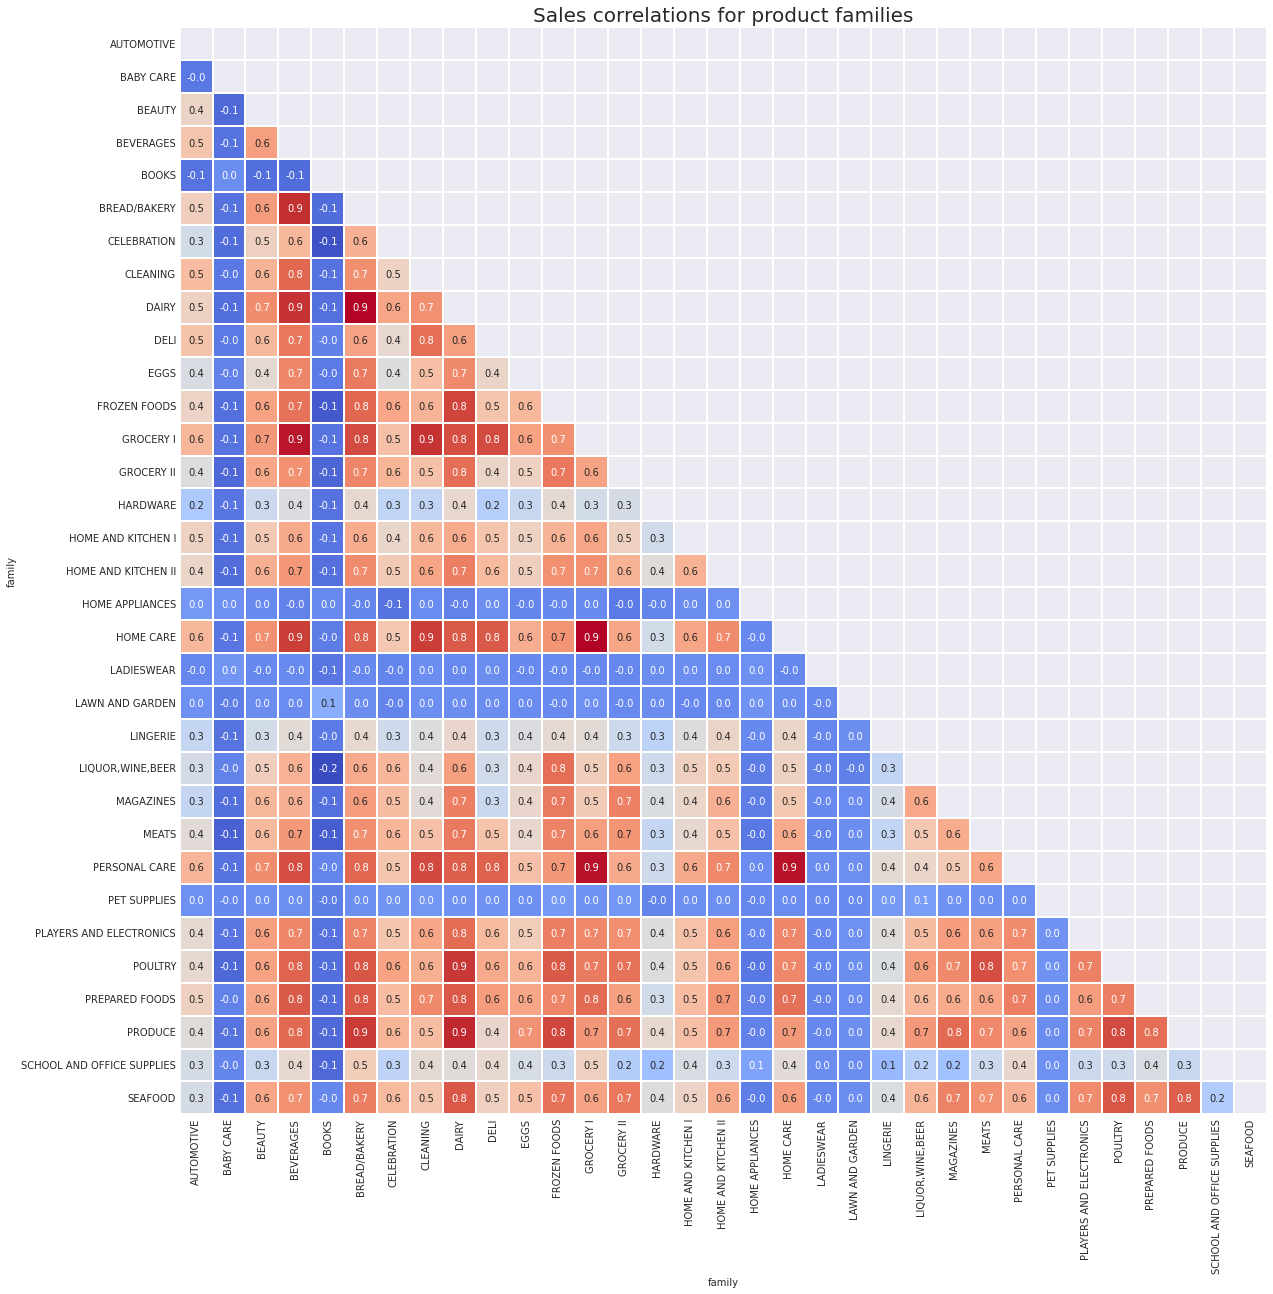

In [70]:
# from 2017-04-30 for faster calculation
# 일부 날짜만 상관관계 측정
a = train["2017-04-30":].reset_index()

a["ind"] = 1
a["ind"] = a.groupby("family").ind.cumsum().values

# 데이터 정렬
a = pd.pivot(a, index = "ind", columns = "family", values = "sales").corr(method="spearman")

mask = np.triu(a.corr(method="spearman"))

# heatmap size
plt.figure(figsize=(20, 20))

# heatmap design
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)

# heatmap title
plt.title("Sales correlations for product families",fontsize = 20)

plt.show()

**pd.pivot**

: 여러 분류로 섞인 행 데이터를 열 데이터로 회전시키는 함수

**np.triu**

: 상삼각행렬에 해당하는 원소만 남길 수 있는 함수

`Output `

- 상관관계가 **전혀 없는** 제품 : `BABY CARE, BOOKS, HOME APPLIANCES, LADIESWEAR, LAWN AND GARDEN, PET SUPPLIES` 
- 상관관계가 **낮은** 제품 : `SCHOOL AND OFFICE SUPPLIES, LINGERIE`
- 상관관계가 **높은** 제품 : 나머지


따라서, 상관관계가 높은 feature값들이 많으므로 다변량 시계열 분석이 필요하다.

### Low Correlation

- 상관관계가 낮은 제품들 살펴보기

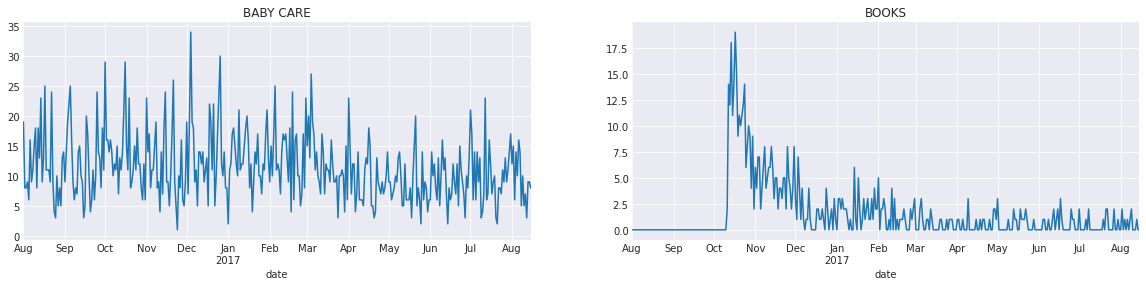

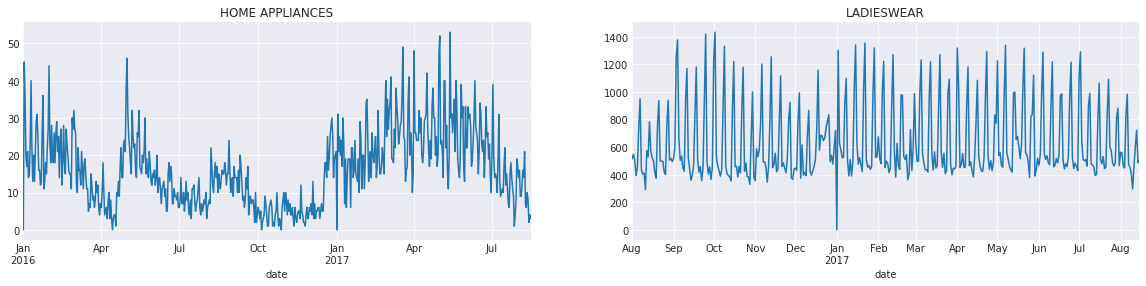

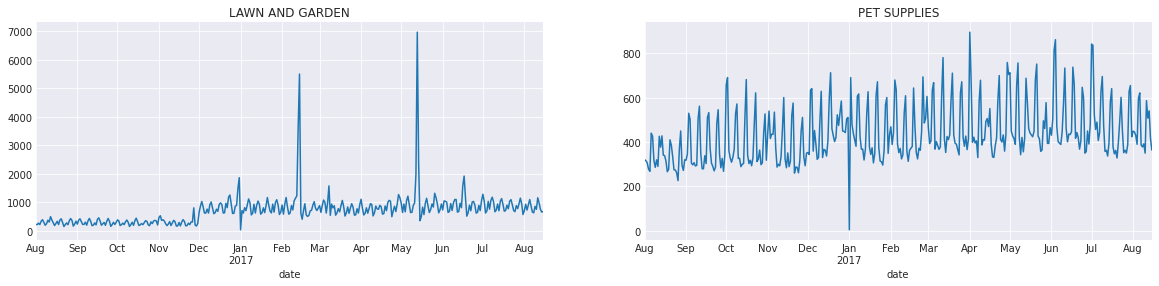

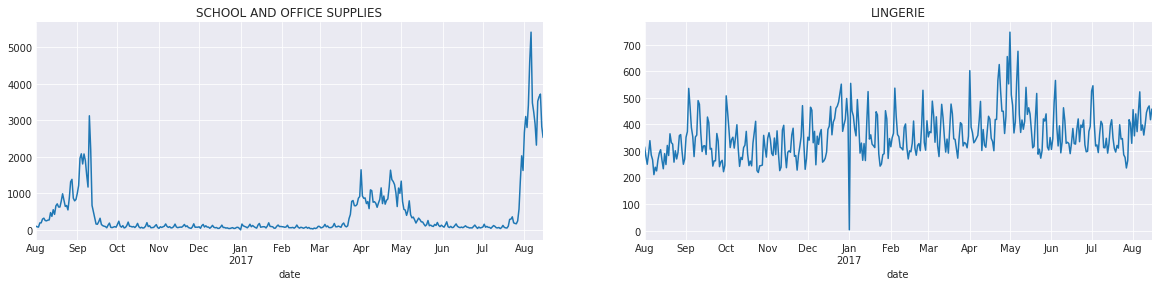

In [71]:
# BABY CARE, BOOKS
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-08-01":].filter(like = 'BABY CARE', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "BABY CARE")
train.loc["2016-08-01":].filter(like = 'BOOKS', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "BOOKS")
plt.show()

# HOME APPLIANCES, LADIESWEAR
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-01-01":].filter(like = 'HOME APPLIANCES', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "HOME APPLIANCES")
train.loc["2016-08-01":].filter(like = 'LADIESWEAR', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "LADIESWEAR")
plt.show()

# LAWN AND GARDEN, PET SUPPLIES
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-08-01":].filter(like = 'LAWN AND GARDEN', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "LAWN AND GARDEN")
train.loc["2016-08-01":].filter(like = 'PET SUPPLIES', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "PET SUPPLIES")
plt.show()

# SCHOOL AND OFFICE SUPPLIES, LINGERIE
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-08-01":].filter(like = 'SCHOOL AND OFFICE SUPPLIES', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "SCHOOL AND OFFICE SUPPLIES")
train.loc["2016-08-01":].filter(like = 'LINGERIE', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "LINGERIE")
plt.show()

`Output `

- `date` : 1월 1일은 매출이 제로다. 즉 1월 1일은 가게들이 문을 닫으므로 **2017.01.01 이후 기간을 선택**해야한다.
- `SCHOOL AND OFFICE SUPPLIES` : Non-stationary Time Series data처럼 보이므로, linear model이 아닌 **tree based models**을 사용해야한다.
- `BOOKS` : 책의 경우 거의 매일 판매되지 않으므로, **tree based models**을 사용해야한다.
- `LAWN AND GARDEN` : 2016년 12월부터 판매 수가 증가했는데, 아마도 전국적으로 많은 매장에서 이 제품군을 도입한 것 같다. 따라서 최소한 **2017-01-02년부터 기간을 선택** 해야한다.
- `HOME APPLIANCES` : Non-stationary Time Series data처럼 보이므로, linear model이 아닌 **tree based models**을 사용해야한다.

- `PET SUPPLYS` : Non-stationary Time Series data처럼 보이지만 명확하지 않으므로 확인해봐야한다.
- `LINGERIE` : Stationary Time Series data처럼 보이지만 명확하지 않으므로 확인해봐야한다.

- **Stationary 확인**
  - `PET SUPPLYS`
  - `LINGERIE`

In [72]:
# PET SUPPLYS 검정력 확인
result = adfuller(
    np.log1p(
        y.loc["2016-08-01":, y.columns.get_level_values("family").isin(["PET SUPPLIES"])].mean(axis="columns")
    )
)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["1%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.753177
p-value: 0.403943
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
Failed to Reject Ho - Time Series is Non-Stationary


`Output `

`PET SUPPLYS`는 Non-Stationary이므로, **tree based models**을 사용해야한다.

In [73]:
# LINGERIE 검정력 확인
result = adfuller(
    np.log1p(
        y.loc["2016-08-01":, y.columns.get_level_values("family").isin(["LINGERIE"])].mean(axis="columns")
    )
)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["1%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -2.159777
p-value: 0.221167
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
Failed to Reject Ho - Time Series is Non-Stationary


`Output `

`LINGERIE`는 Non-Stationary이므로, **tree based models**을 사용해야한다.

## Top Selling Products
- 가장 많이 팔리는 제품군 살펴보기

In [74]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()

# 막대 그래프
px.bar(a, y = "family", x="sales", color = "family", title = "Top selling product families")

`Output `

`GROCERY, BEVERAGES, PRODUCE`가 가장 많이 팔리는 제품군 Top 3다.

반면, `MAGAZINES,LAWN AND GARDEN,BABY CARE, CELEBRATION,GROCERY II, HARDWARE, AUTOMOTIVE, HOME AND KITCHEN I,HOME AND KITCHEN II, HOME APPLIANCES, LINGERIE, LADIESWEAR, SEAFOOD, PLAYERS AND ELECTRONICS, PET SUPPLIES, BEAUTY, PREPARED FOODS, HOME CARE, CLEANING`은 잘 팔리지 않는다.

## Top Selling Store
- 가장 판매량이 좋은 매장 살펴보기

In [78]:
b = train.groupby("store_nbr").sales.mean().sort_values(ascending = False).reset_index()

# 막대 그래프
px.bar(b, y = "store_nbr", x="sales", color = "store_nbr", title = "Top selling stores")

`Output `

`44, 45, 47`가 가장 매출이 높은 매장 Top 3다.

반면, `52, 22, 32`는 매출이 높진 않지만, 제품군보다 액수 간 차이가 적다.

# Feature Engineering (Self)

In [79]:
# train data 다시 불러오기
df = pd.read_csv('/content/drive/MyDrive/kaggle/store-sales-time-series-forecasting/train.csv')

df.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


## Imputation

In [80]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

## Outliers

### Store_nbr & Sales

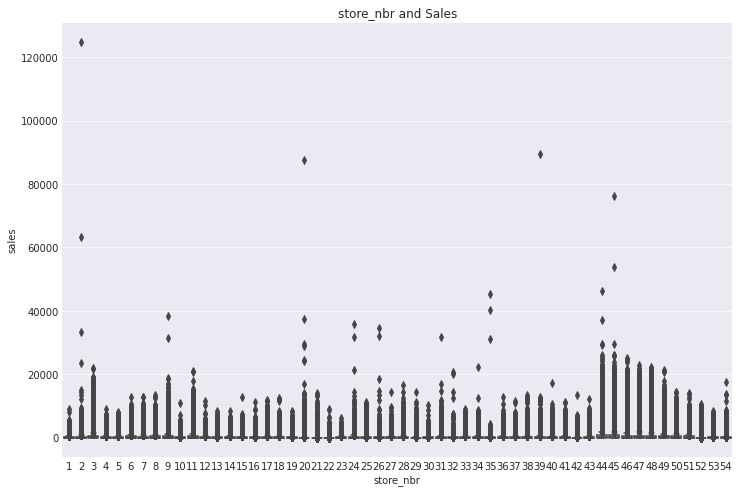

In [82]:
plt.figure(figsize = (12,8))
plt.title('store_nbr and Sales')
sns.boxplot(x = 'store_nbr', y = 'sales', data = df)
plt.show()